In [ ]:
# # Brain Stroke Detection using Deep Learning

In [ ]:
# This project aims to build a deep learning model to predict the likelihood of a brain stroke based on various health parameters.

In [4]:

# ## 1. Import Required Libraries

In [5]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [6]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
# ## 2. Load and Explore the Dataset


In [9]:
 df = pd.read_csv('archive.zip')

ValueError: Multiple files found in ZIP file. Only one file per ZIP: ['full_data.csv', 'full_filled_stroke_data (1).csv']

In [10]:
# Read a specific file from the ZIP archive
df = pd.read_csv('archive.zip', compression='zip', header=0, sep=',', quotechar='"')

# Or explicitly specify the filename:
df = pd.read_csv('zip://full_data.csv')  # Use the correct filename

ValueError: Multiple files found in ZIP file. Only one file per ZIP: ['full_data.csv', 'full_filled_stroke_data (1).csv']

In [11]:
 df = pd.read_csv('full_data.csv')

In [12]:
# Display basic info
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (4981, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [13]:
# %%
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [14]:
# Drop rows with missing values (or you could impute them)
df = df.dropna()

In [15]:
# Check the dataset after handling missing values
print("\nDataset Shape after dropping missing values:", df.shape)



Dataset Shape after dropping missing values: (4981, 11)


In [16]:
# %%
# Exploratory Data Analysis
print("\nDataset Information:")
print(df.info())



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB
None


In [17]:
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
               age  hypertension  heart_disease  avg_glucose_level  \
count  4981.000000   4981.000000    4981.000000        4981.000000   
mean     43.419859      0.096165       0.055210         105.943562   
std      22.662755      0.294848       0.228412          45.075373   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.230000   
50%      45.000000      0.000000       0.000000          91.850000   
75%      61.000000      0.000000       0.000000         113.860000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4981.000000  4981.000000  
mean     28.498173     0.049789  
std       6.790464     0.217531  
min      14.000000     0.000000  
25%      23.700000     0.000000  
50%      28.100000     0.000000  
75%      32.600000     0.000000  
max      48.900000     1.000000  


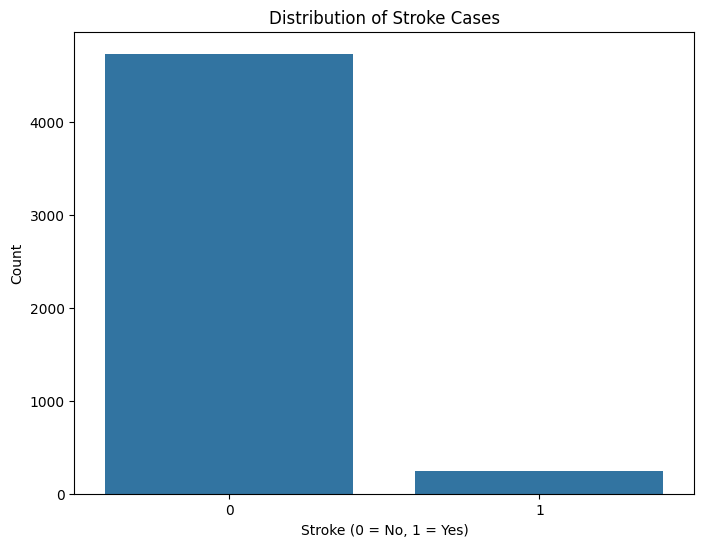

In [18]:
# %%
# Visualize the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='stroke', data=df)
plt.title('Distribution of Stroke Cases')
plt.xlabel('Stroke (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


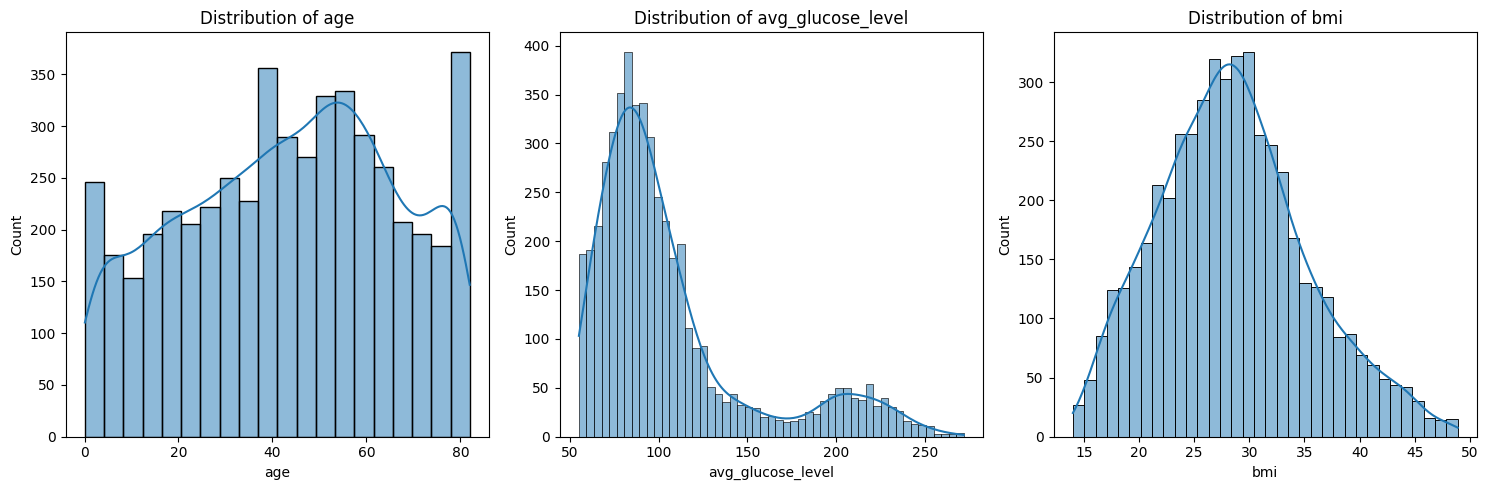

In [19]:
# %%
# Visualize numerical features
numerical_features = ['age', 'avg_glucose_level', 'bmi']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


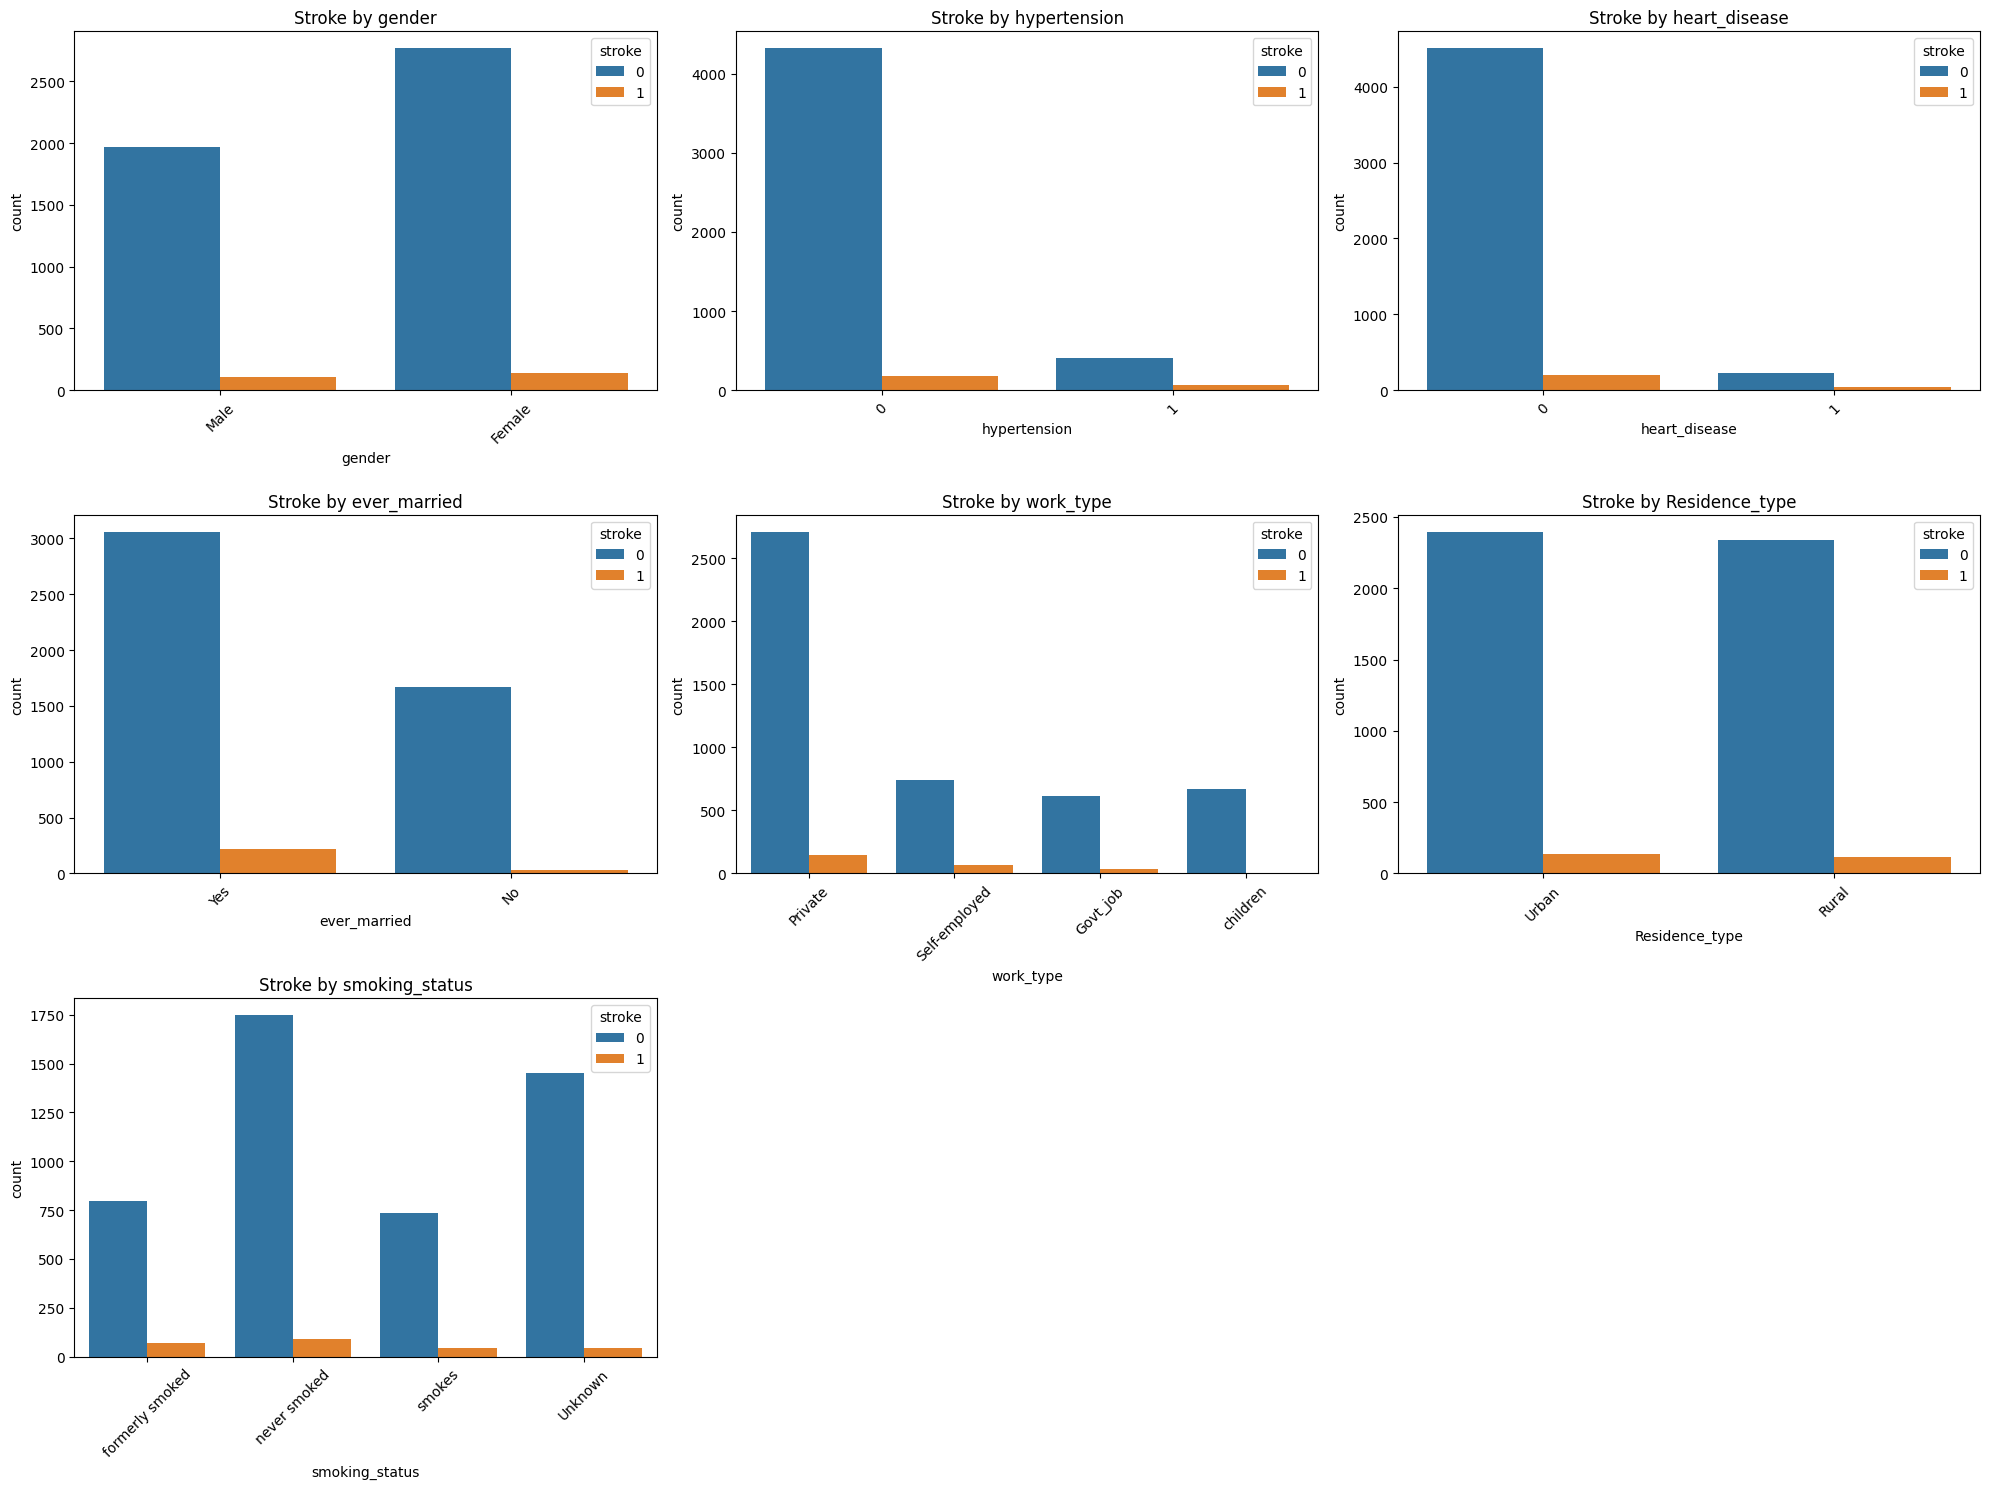

In [20]:
# %%
# Visualize categorical features
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                       'work_type', 'Residence_type', 'smoking_status']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=feature, hue='stroke', data=df)
    plt.title(f'Stroke by {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# ## 3. Data Preprocessing


In [22]:
# Define features and target
X = df.drop('stroke', axis=1)
y = df['stroke']


In [23]:
# %%
# Identify categorical and numerical columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]


In [24]:
print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numerical Columns: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']


In [25]:
# %%
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


In [26]:
# Apply preprocessing
X_processed = preprocessor.fit_transform(X)


In [27]:
# %%
# Check class imbalance
print("Class Distribution:")
print(y.value_counts())

Class Distribution:
stroke
0    4733
1     248
Name: count, dtype: int64


In [28]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_processed, y)


In [29]:
print("\nClass Distribution after SMOTE:")
print(pd.Series(y_res).value_counts())



Class Distribution after SMOTE:
stroke
1    4733
0    4733
Name: count, dtype: int64


In [30]:
# %%
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)


In [31]:
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (7572, 19)
Testing set shape: (1894, 19)


In [32]:
# ## 4. Build the Deep Learning Model

In [33]:
# Define the model architecture
def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [34]:
# Create the model
input_shape = X_train.shape[1]
model = create_model(input_shape)

# Display model summary
model.summary()

# %% [markdown]
# ## 5. Train the Model

# %%
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# %%
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,377 (52.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6179 - loss: 2.2155 - val_accuracy: 0.7538 - val_loss: 1.6250 - learning_rate: 0.0010
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7414 - loss: 1.5238 - val_accuracy: 0.7855 - val_loss: 1.2063 - learning_rate: 0.0010
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7712 - loss: 1.1463 - val_accuracy: 0.8013 - val_loss: 0.9321 - learning_rate: 0.0010
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7819 - loss: 0.9128 - val_accuracy: 0.8106 - val_loss: 0.7590 - learning_rate: 0.0010
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7829 - loss: 0.7542 - val_accuracy: 0.8172 - val_loss: 0.6451 - learning_rate: 0.0010
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7869 - loss: 0.6647 - val_accuracy: 0.8257 - val_loss: 0.5732 - learning_rate: 0.0010
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7926 - loss: 0.

In [35]:
# ## 6. Evaluate the Model

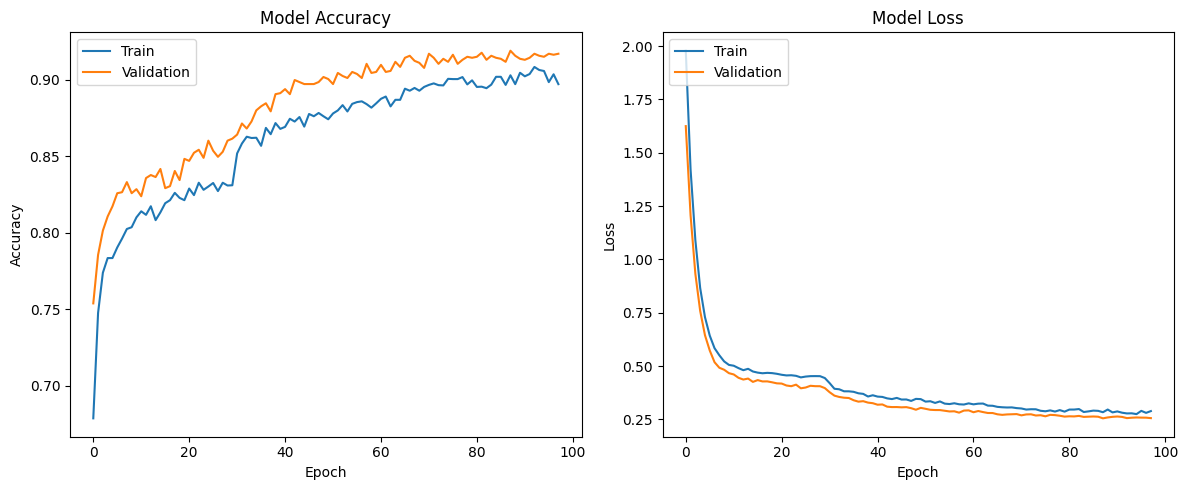

In [36]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9134
ROC AUC Score: 0.9592

Confusion Matrix:
[[805 142]
 [ 22 925]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       947
           1       0.87      0.98      0.92       947

    accuracy                           0.91      1894
   macro avg       0.92      0.91      0.91      1894
weighted avg       0.92      0.91      0.91      1894



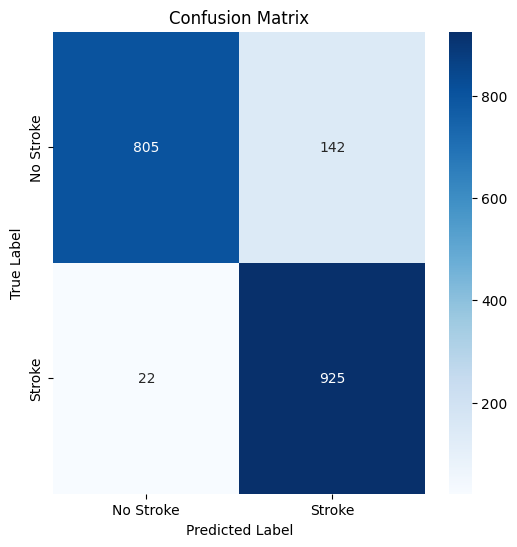

In [37]:
# Evaluate on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# %%
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
             xticklabels=['No Stroke', 'Stroke'],
             yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


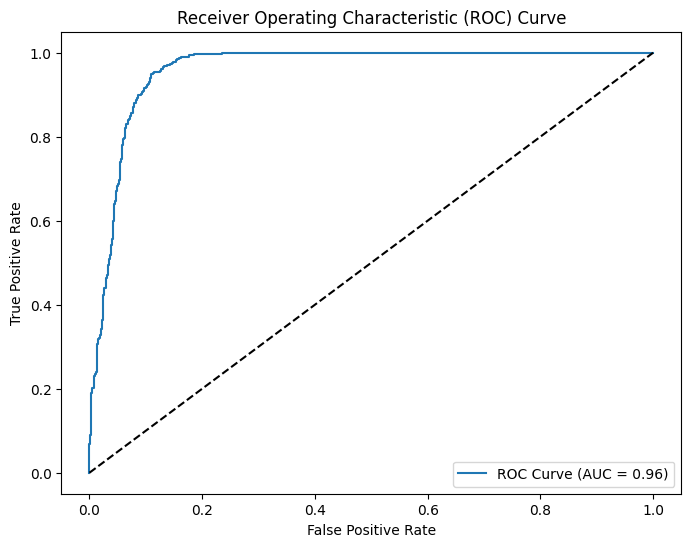

In [38]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [39]:
# ## 7. Save the Model and Preprocessor


In [40]:
# Save the model
model.save('brain_stroke_detection_model.h5')


In [41]:
# Save the preprocessor
import joblib
joblib.dump(preprocessor, 'preprocessor.pkl')

print("Model and preprocessor saved successfully!")


Model and preprocessor saved successfully!


In [42]:
# ## 8. Create a Prediction Function

In [43]:
# %%
def predict_stroke(input_data):
    """
    Function to predict stroke probability based on input data
    Input should be a dictionary with the following keys:
    {
        'gender': str,
        'age': float,
        'hypertension': int,
        'heart_disease': int,
        'ever_married': str,
        'work_type': str,
        'Residence_type': str,
        'avg_glucose_level': float,
        'bmi': float,
        'smoking_status': str
    }
    """

In [46]:
# Convert input to DataFrame
input_df = pd.DataFrame([input_data])

NameError: name 'input_data' is not defined

In [47]:
def predict_stroke(input_data):
    """
    Function to predict stroke probability based on input data
    Input should be a dictionary with the following keys:
    {
        'gender': str,
        'age': float,
        'hypertension': int,
        'heart_disease': int,
        'ever_married': str,
        'work_type': str,
        'Residence_type': str,
        'avg_glucose_level': float,
        'bmi': float,
        'smoking_status': str
    }
    """
    # Convert input to DataFrame
    input_df = pd.DataFrame([input_data])

    # Preprocess the input data
    input_processed = preprocessor.transform(input_df)

    # Make prediction
    prediction_prob = model.predict(input_processed)[0][0]
    prediction = (prediction_prob > 0.5).astype(int)

    return prediction, prediction_prob

In [48]:
# Example usage
example_input = {
    'gender': 'Male',
    'age': 67,
    'hypertension': 1,
    'heart_disease': 1,
    'ever_married': 'Yes',
    'work_type': 'Private',
    'Residence_type': 'Urban',
    'avg_glucose_level': 228.69,
    'bmi': 36.6,
    'smoking_status': 'formerly smoked'
}

prediction = predict_stroke(example_input)
print("\nExample Prediction:")
for key, value in prediction.items():
    print(f"{key}: {value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Example Prediction:


AttributeError: 'tuple' object has no attribute 'items'

In [49]:
# Example usage
example_input = {
    'gender': 'Male',
    'age': 67,
    'hypertension': 1,
    'heart_disease': 1,
    'ever_married': 'Yes',
    'work_type': 'Private',
    'Residence_type': 'Urban',
    'avg_glucose_level': 228.69,
    'bmi': 36.6,
    'smoking_status': 'formerly smoked'
}

prediction, prediction_prob = predict_stroke(example_input)
print("\nExample Prediction:")
print(f"Predicted Stroke: {prediction}")
print(f"Prediction Probability: {prediction_prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Example Prediction:
Predicted Stroke: 1
Prediction Probability: 0.9840
